In [1]:
import numpy as np
from fastai import *
import csv
from glob import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import fastai
# from fastai.data.core import DataLoaders
# from fastai.vision.learner import *
from fastai.basics import *
# from fastai.vision.core import *
# from fastai.vision.data import *
# from fastai.vision.augment import *
# from fastai.vision import models
# from fastai.vision.learner import Learner
from fastai.vision.all import *
from fastai.callback.schedule import lr_find
from torch import nn
import torch.nn.functional as F

In [2]:
# sudoPassword = 'rare886apt269'
# command = ['sudo rmmod nvidia_uvm', 'sudo modprobe nvidia_uvm']
# if not torch.cuda.is_available():
#     os.system('echo %s|sudo -S %s' % (sudoPassword, command[0]))
#     os.system('echo %s|sudo -S %s' % (sudoPassword, command[1]))
# torch.cuda.is_available()

In [3]:
# imgs = '/media/sarvagya/66e1ccd6-9d4b-4a61-8750-36e2e23d8988/solar/11/'
# days = (sorted(os.listdir(imgs)))
# files = []
# for day in days:
# #     print("#####################")
# #     print(sorted(glob(imgs+month+'/*.npz')))
#     img = sorted(glob(imgs+day+'/*.npz'))
#     for i in img:
#         files.append(i)

In [4]:
# len(files)

In [5]:
# column_name = ['image']
# with open('output.csv', 'w') as w:
#     write = csv.writer(w)
#     write.writerow(column_name)

In [6]:
# for file in files:
#     with open('output.csv', 'a') as w:
#         write = csv.writer(w)
#         write.writerow([file])

In [7]:
df = pd.read_csv('output.csv', error_bad_lines=False)

In [8]:
# df

In [9]:
X = list(df['image'])

In [10]:
# tmp = np.load(X[0], allow_pickle=True)
# img = tmp['x']
# img = np.reshape(img,(1,img.shape[0], img.shape[1]))
# img = torch.from_numpy(img).float()
# print(img.shape)
# imgs = get_image_files(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, X, test_size=0.33, random_state=42)

In [12]:
# type(X_train)
# len(y_train)
# dblock = DataBlock(blocks=(ImageBlock, PointBlock),
#                    get_items=X_train,
#                    splitter=RandomSplitter(),
#                    get_y=tensor(y_train))

In [13]:
class data_gen(torch.utils.data.Dataset):
    def __init__(self, files):
        
        self.files = files
        
        
    def __getitem__(self, i):
        
        file1 = self.files[i]
        
        tmp = np.load(file1, allow_pickle=True)
        
        img = tmp['x']
        img = np.reshape(img,(1,img.shape[0], img.shape[1]))
        img = torch.from_numpy(img).float()
        
        return (img, img)

    def __len__(self): 
        
        return len(self.files)

In [14]:
train_ds = data_gen(X_train)
test_ds = data_gen(X_test)

In [15]:
batch_size = 8
dls = DataLoaders.from_dsets(train_ds, test_ds, bs=batch_size, device='cuda:0')

In [16]:
b,_ = dls.one_batch()

In [17]:
# b.size()
# dls.show_batch()

In [18]:
# learn = unet_learner(dls, models.resnet34)

In [19]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Input size: [batch, 3, 32, 32]
#         # Output size: [batch, 3, 32, 32]
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1,12,4,stride=2,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(12,24,4,stride=2,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(24,48,4,stride=2,padding=1),
#             nn.ReLU(),
#             )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(48,24,4,stride=2,padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(24,12,4,stride=2,padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(12,1,4,stride=2,padding=1),
#             nn.Sigmoid(),
#             )    
#         def encode(self, x): return self.encoder(x)    
        
#         def decode(self, x): return self.decoder(x)    
#         def forward(self, x):
#             encoded = self.encoder(x)
#             decoded = self.decoder(encoded)
#             return decoded
m = fastai.vision.models.resnet34(pretrained = False).cuda()

In [20]:
# autoencoder = Autoencoder()
m = nn.Sequential(*list(m.children())[:-3])

In [21]:
code_sz = 32

conv = nn.Conv2d(256, code_sz, kernel_size=(2,2)).cuda()

m.add_module('CodeIn',conv)

In [22]:
m._modules['0'] = nn.Conv2d(1, 64, kernel_size=(7,7),stride=2,padding=1).cuda()
# m._modules['1'] = nn.BatchNorm2d(batch_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).cuda()
# m

In [23]:
# autoencoder(b)
m(b).size()

torch.Size([8, 32, 31, 31])

In [24]:
# learn = Learner(data, autoencoder, loss_func = F.mse_loss)
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

In [25]:
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)

In [26]:
add_layer(m,code_sz,256,'CodeOut',out_shape=(64,64),scale=None)
add_layer(m,256,128,'Upsample0')
add_layer(m,128,64,'Upsample1')
add_layer(m,64,32,'Upsample2')
add_layer(m,32,1,'Upsample3',act='sig', scale=1)

In [27]:
m(b).size()
# b.size()
# m

torch.Size([8, 1, 512, 512])

In [30]:
learn = Learner(dls=dls,model=m,loss_func=F.mse_loss)

In [31]:
# learn.final_record
learn.summary()

Sequential (Input shape: ['8 x 1 x 512 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 254 x 254   3,200      True      
________________________________________________________________
BatchNorm2d          8 x 64 x 254 x 254   128        True      
________________________________________________________________
ReLU                 8 x 64 x 254 x 254   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 127 x 127   0          False     
________________________________________________________________
Conv2d               8 x 64 x 127 x 127   36,864     True      
________________________________________________________________
BatchNorm2d          8 x 64 x 127 x 127   128        True      
________________________________________________________________
ReLU                 8 x 64 x 127 x 127   0          False     
__________________________________________________

In [34]:
# fastai.__version__
lr = 1e-2

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=2.511886486900039e-05)

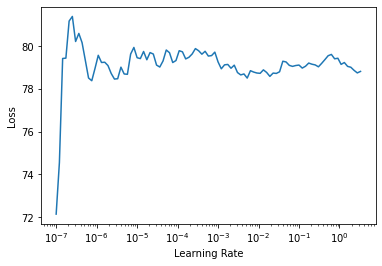

In [33]:
# learn.fit(10,lr)
# for i in dls.train_ds:
#     print(i.shape)
# count = 0
# for i in dls.train:
#     print(count+1)
#     print(i.shape)
#     count+=1
lr_find(learn)

In [35]:
# lr = 2.75e-7
learn.fit(20,lr)

epoch,train_loss,valid_loss,time
0,77.224052,77.531769,01:21
1,77.483757,76.730850,01:22
2,77.434334,76.532478,01:23
3,77.505379,76.442963,01:25
4,76.459488,76.477005,01:24
5,77.156502,76.351067,01:25
6,76.941597,76.333847,01:24
7,77.181450,76.344879,01:22
8,77.173126,76.304436,01:22
9,77.042160,76.253128,01:22


In [36]:
learn.save('model_20ep')

Path('models/model_20ep.pth')